In [1]:
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", 120)
pd.options.mode.copy_on_write = True  

In [2]:
def mem(df, name="df"):
    mb = df.memory_usage(deep=True, index=True).sum() / (1024**2)
    print(f"{name}: {mb:,.1f} MB, shape={df.shape}")

In [3]:
def safe_ratio(num, den):
    num = pd.to_numeric(num, errors="coerce")
    den = pd.to_numeric(den, errors="coerce")
    return num.div(den).replace([np.inf, -np.inf], np.nan).fillna(0.0)

In [4]:
def downcast_ints(df, exclude=()):
    for c in df.columns:
        if c in exclude: 
            continue
        if pd.api.types.is_integer_dtype(df[c]):
            df[c] = pd.to_numeric(df[c], downcast="integer")
    return df

In [5]:
def rename_cols_inplace(df, mapping):
    df.rename(columns=mapping, inplace=True)
    return df

In [6]:
USECOLS_ENR = [
    "pseudocode","item_group","item_id","cpp_b","cpp_g",
    "c1_b","c1_g","c2_b","c2_g","c3_b","c3_g","c4_b","c4_g","c5_b","c5_g",
    "c6_b","c6_g","c7_b","c7_g","c8_b","c8_g","c9_b","c9_g","c10_b","c10_g","c11_b","c11_g","c12_b","c12_g"
]
DTYPES_ENR = {col:"Int32" for col in USECOLS_ENR}
DTYPES_ENR["pseudocode"] = "int64"   # key stays int64 while we aggregate
DTYPES_ENR["item_group"] = "int16"
DTYPES_ENR["item_id"] = "int16"

def _read_enr_chunk(path, chunksize=400_000):
    for chunk in pd.read_csv(path, usecols=USECOLS_ENR, dtype=DTYPES_ENR, chunksize=chunksize):
        yield chunk

def build_school_enrol(paths):
    out = None
    for path in paths:
        for chunk in _read_enr_chunk(path):
            # totals per row
            boys_cols  = [c for c in chunk.columns if c.endswith("_b")]
            girls_cols = [c for c in chunk.columns if c.endswith("_g")]
            chunk["tot_b"] = chunk[boys_cols].sum(axis=1, skipna=True)
            chunk["tot_g"] = chunk[girls_cols].sum(axis=1, skipna=True)

            g = (chunk.groupby("pseudocode", observed=True)[["tot_b","tot_g"]]
                      .sum()
                      .reset_index())
            out = g if out is None else (
                pd.concat([out, g], ignore_index=True)
                  .groupby("pseudocode", observed=True)[["tot_b","tot_g"]]
                  .sum().reset_index()
            )
            del chunk, g
            gc.collect()
    out = rename_cols_inplace(out, {"pseudocode":"school_id"})
    out["gpi"] = safe_ratio(out["tot_g"], out["tot_b"])
    return downcast_ints(out, exclude=("school_id",))

In [7]:
enrol = build_school_enrol(["E:\\PROJECTS\\Datathon\\datasets\\100_enr1.csv","E:\\PROJECTS\\Datathon\\datasets\\100_enr2.csv"])
mem(enrol, "enrol")
enrol.head()

enrol: 32.1 MB, shape=(1463480, 4)


,school_id,tot_b,tot_g,gpi
0,1000002,118,109,0.923729
1,1000019,41,25,0.609756
2,1000021,95,97,1.021053
3,1000028,71,41,0.577465
4,1000029,589,463,0.786078


In [8]:
enrol.tail()

,school_id,tot_b,tot_g,gpi
1463475,9999978,150,115,0.766667
1463476,9999982,347,433,1.247839
1463477,9999988,160,113,0.70625
1463478,9999994,67,55,0.820896
1463479,9999996,54,26,0.481481


In [9]:
enrol.describe()

,school_id,tot_b,tot_g,gpi
count,1.463480e+06,1463480.0,1463480.0,1463480.0
mean,5.500648e+06,225.023238,212.565678,1.146573
std,2.598056e+06,395.684003,378.176176,10.064421
min,1.000002e+06,0.0,0.0,0.0
25%,3.250121e+06,43.0,43.0,0.729167
50%,5.499454e+06,104.0,101.0,0.929412
75%,7.749516e+06,244.0,231.0,1.159091
max,9.999996e+06,21219.0,29712.0,2892.0


In [10]:
enrol.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1463480 entries, 0 to 1463479
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   school_id  1463480 non-null  int64  
 1   tot_b      1463480 non-null  Int16  
 2   tot_g      1463480 non-null  Int16  
 3   gpi        1463480 non-null  Float64
dtypes: Float64(1), Int16(2), int64(1)
memory usage: 32.1 MB


In [11]:
enrol.shape

(1463480, 4)

In [12]:
use_cols = (
    ["pseudocode", "item_group", "cpp_b", "cpp_g"]
    + [f"c{i}_b" for i in range(1,13)]
    + [f"c{i}_g" for i in range(1,13)]
)

In [13]:
dtype_small = {col: "int32" for col in use_cols if col != "pseudocode"}
dtype_small["pseudocode"] = "int32"
dtype_small["item_group"] = "int8" 

In [14]:
def add_repeaters_cwsn(d_csv_paths, enrol):
    rep = None; cwsn = None
    for path in d_csv_paths:
        for chunk in pd.read_csv(path, usecols=use_cols, dtype=dtype_small, chunksize=750_000):
            boys_cols  = ["cpp_b"] + [f"c{i}_b" for i in range(1,13)]
            girls_cols = ["cpp_g"] + [f"c{i}_g" for i in range(1,13)]
            chunk["tot_b"] = chunk[boys_cols].sum(axis=1)
            chunk["tot_g"] = chunk[girls_cols].sum(axis=1)
            # Repeaters: group=5 (per schema)
            r = (chunk.loc[chunk["item_group"]==5]
                       .groupby("pseudocode")[["tot_b","tot_g"]].sum().reset_index())
            rep = r if rep is None else pd.concat([rep,r]).groupby("pseudocode")[["tot_b","tot_g"]].sum().reset_index()
            # CWSN: group=4
            c = (chunk.loc[chunk["item_group"]==4]
                       .groupby("pseudocode")[["tot_b","tot_g"]].sum().reset_index())
            cwsn = c if cwsn is None else pd.concat([cwsn,c]).groupby("pseudocode")[["tot_b","tot_g"]].sum().reset_index()
            del chunk, r, c; gc.collect()

    for df, base, bname in [(rep, "rep", "repeaters"), (cwsn, "cwsn", "cwsn")]:
        if df is not None:
            rename_cols_inplace(df, {"pseudocode":"school_id", "tot_b":f"{base}_b", "tot_g":f"{base}_g"})
            enrol = enrol.merge(df, on="school_id", how="left")
            enrol[[f"{base}_b",f"{base}_g"]] = enrol[[f"{base}_b",f"{base}_g"]].fillna(0).astype("int32")
            enrol[f"{bname}_share"] = safe_ratio(enrol[f"{base}_b"]+enrol[f"{base}_g"],
                                                 enrol["tot_b"]+enrol["tot_g"])
    return enrol

In [15]:
enrol = add_repeaters_cwsn(["E:\\PROJECTS\\Datathon\\datasets\\100_enr1.csv","E:\\PROJECTS\\Datathon\\datasets\\100_enr2.csv"],enrol)

In [16]:
enrol.to_parquet("enrol_by_school.parquet", index=False)

In [17]:
def rename_cols_inplace(df, mapping: dict):
    df.rename(columns=mapping, inplace=True)
    return df

In [18]:
def to_cats(df, cols):
    for c in cols:
        if c in df.columns:
            df[c] = df[c].astype("category")
    return df

In [19]:
def safe_ratio(num, den):
    return num / den.replace({0: np.nan})

In [20]:
def downcast_ints(df, exclude=()):
    for col in df.select_dtypes(include="int").columns:
        if col not in exclude:
            df[col] = pd.to_numeric(df[col], downcast="integer")
    return df

In [21]:
def mem(df, name):
    print(f"{name}: {df.memory_usage(deep=True).sum()/1024/1024:.2f} MB")

In [22]:
#prof1
d4_cols = ["pseudocode","state","district","block","rural_urban",
           "school_category","school_type","managment","lowclass","highclass"]
d4 = pd.read_csv("E:\\PROJECTS\\Datathon\\datasets\\100_prof1.csv", usecols=d4_cols,
                 dtype={"pseudocode":"int32","rural_urban":"int8",
                        "school_category":"int8","school_type":"int8",
                        "managment":"int16","lowclass":"int8","highclass":"int8"})
rename_cols_inplace(d4, {"pseudocode":"school_id"})
to_cats(d4, ["state","district","block"])
mem(d4,"d4_sel")

d4_sel: 23.17 MB


In [23]:
#fac
d3_cols = ["pseudocode","total_boys_func_toilet","total_girls_func_toilet",
           "urinal_boys","urinal_girls","handwash_near_toilet","tap_yn",
           "electricity_availability","library_availability","playground_available",
           "comp_ict_lab_yn","internet","printer","projector","desktop","laptop",
           "smart_class_tv_tot","solar_panel"]
d3 = pd.read_csv("E:\\PROJECTS\\Datathon\\datasets\\100_fac.csv", usecols=d3_cols,
                 dtype={c:"int32" for c in d3_cols})
rename_cols_inplace(d3, {"pseudocode":"school_id"})
d3 = downcast_ints(d3, exclude=("school_id",))
mem(d3,"d3_sel")

d3_sel: 39.29 MB


In [24]:
#prof2
d5_cols = ["pseudocode","balavatika_located_yn","special_training",
           "free_text_books_pr","free_uniform_pr","free_text_books_up","free_uniform_up",
           "acad_inspections","crc_coordinator","block_level_officers","district_officers",
           "smc_exists","smc_smdc_same","smc_smdc_meetings",
           "grants_receipt","grants_expenditure"]
d5 = pd.read_csv("E:\\PROJECTS\\Datathon\\datasets\\100_prof2.csv", usecols=d5_cols,
                 dtype={**{c:"int32" for c in d5_cols if c!="grants_receipt" and c!="grants_expenditure"},
                        "grants_receipt":"float32","grants_expenditure":"float32"})
rename_cols_inplace(d5, {"pseudocode":"school_id"})
d5 = downcast_ints(d5, exclude=("school_id",))
mem(d5,"d5_sel")


d5_sel: 35.08 MB


In [25]:
#tch
d6_cols = ["pseudocode","total_tch","male","female","regular","contract","part_time"]
d6 = pd.read_csv("E:\\PROJECTS\\Datathon\\datasets\\100_tch.csv", usecols=d6_cols,
                 dtype={c:"int32" for c in d6_cols})
rename_cols_inplace(d6, {"pseudocode":"school_id"})
d6 = downcast_ints(d6, exclude=("school_id",))
mem(d6,"d6_sel")

d6_sel: 21.05 MB


In [26]:
enrol.to_parquet("enrol_by_school.parquet", index=False)
print("Saved")

Saved


In [27]:
enrol = pd.read_parquet("enrol_by_school.parquet")
mem(enrol,"enrol")

# minimal merges
master = (enrol
          .merge(d6, on="school_id", how="left")
          .merge(d3, on="school_id", how="left")
          .merge(d4, on="school_id", how="left")
          .merge(d5, on="school_id", how="left"))
mem(master, "master_raw")


enrol: 79.55 MB
master_raw: 175.17 MB


In [28]:
master["tot_enrol"] = master["tot_b"] + master["tot_g"]
master["ptr"] = safe_ratio(master["tot_enrol"], master["total_tch"])

In [29]:
master["toilet_b_func_ratio"] = safe_ratio(master["total_boys_func_toilet"], master["total_boys_func_toilet"])
master["toilet_g_func_ratio"] = safe_ratio(master["total_girls_func_toilet"], master["total_girls_func_toilet"])


In [30]:
flags = ["handwash_near_toilet","tap_yn","electricity_availability",
         "library_availability","playground_available","comp_ict_lab_yn","internet","solar_panel"]
for f in flags:
    if f in master.columns:
        master[f+"_bin"] = master[f].isin([1]).astype("int8")

In [31]:
bin_cols = [c for c in master.columns if c.endswith("_bin")]
master["facility_score"] = master[bin_cols].mean(axis=1)

In [32]:
master["low_gpi"] = (master["gpi"] < 0.95).astype("int8")

In [33]:
import matplotlib.pyplot as plt

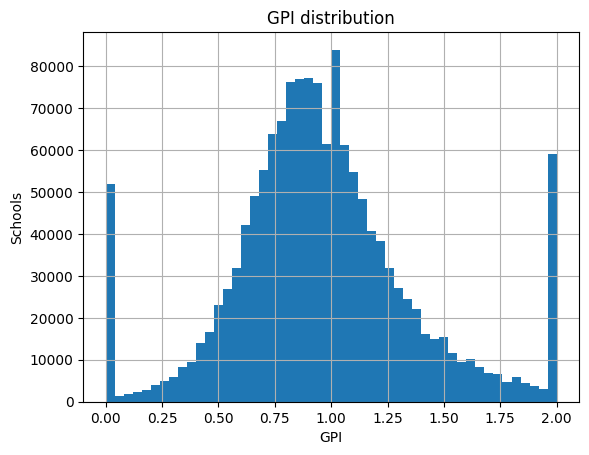

In [34]:
master["gpi"].dropna().clip(0,2).hist(bins=50)
plt.title("GPI distribution")
plt.xlabel("GPI")
plt.ylabel("Schools")
plt.show()

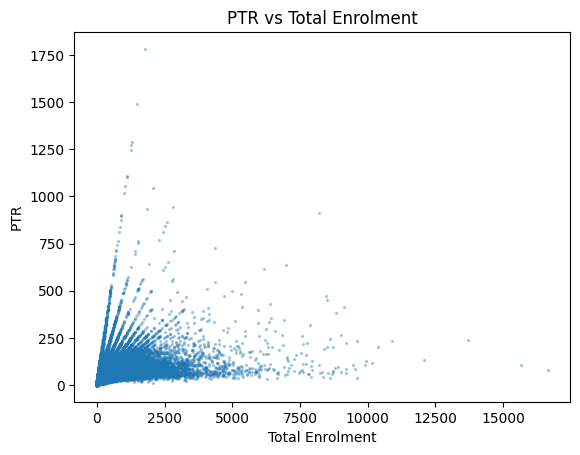

In [36]:
sample1= master[["tot_enrol","ptr"]].dropna().sample(n=min(50000, len(master)), random_state=42)
plt.scatter(sample1["tot_enrol"], sample1["ptr"], s=2, alpha=0.3)
plt.title("PTR vs Total Enrolment")
plt.xlabel("Total Enrolment")
plt.ylabel("PTR")
plt.show()

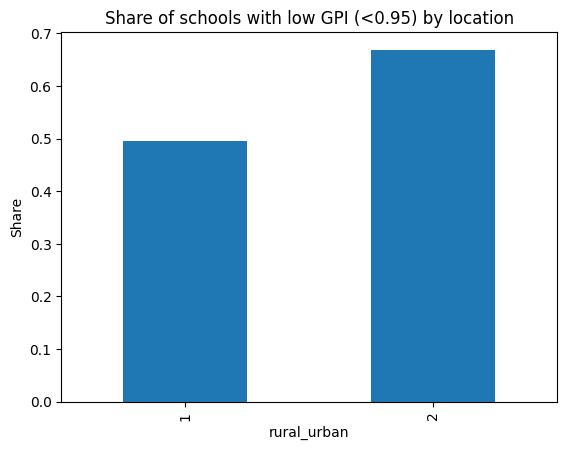

In [37]:
if "rural_urban" in master.columns:
    grp = master.groupby("rural_urban")["low_gpi"].mean()
    grp.plot(kind="bar")
    plt.title("Share of schools with low GPI (<0.95) by location")
    plt.ylabel("Share")
    plt.show()

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report

In [39]:
features = ["ptr","facility_score","tot_enrol"]  
X = master[features].fillna(0).astype("float32")
y = master["low_gpi"].astype("int8")

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
sc = StandardScaler()
Xtr = sc.fit_transform(X_train)
Xte = sc.transform(X_test)

clf = LogisticRegression(max_iter=500, solver="saga", n_jobs=1)
clf.fit(Xtr, y_train)

proba = clf.predict_proba(Xte)[:,1]
pred  = (proba >= 0.5).astype("int8")

print("ROC AUC:", roc_auc_score(y_test, proba))
print(classification_report(y_test, pred, digits=3))

ROC AUC: 0.576225636922904
              precision    recall  f1-score   support

           0      0.525     0.377     0.439    173323
           1      0.553     0.693     0.615    192547

    accuracy                          0.543    365870
   macro avg      0.539     0.535     0.527    365870
weighted avg      0.540     0.543     0.532    365870



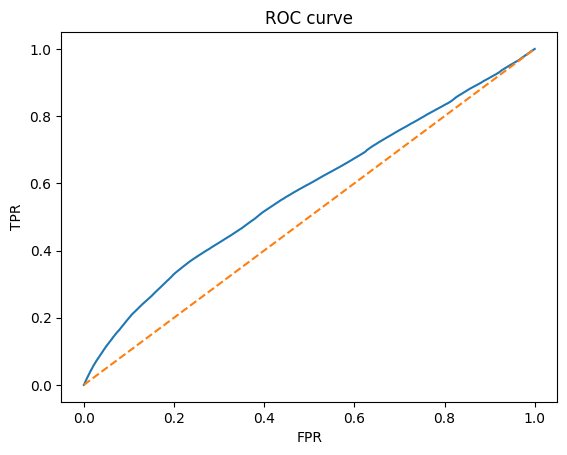

In [41]:
fpr, tpr, _ = roc_curve(y_test, proba)
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'--')
plt.title("ROC curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

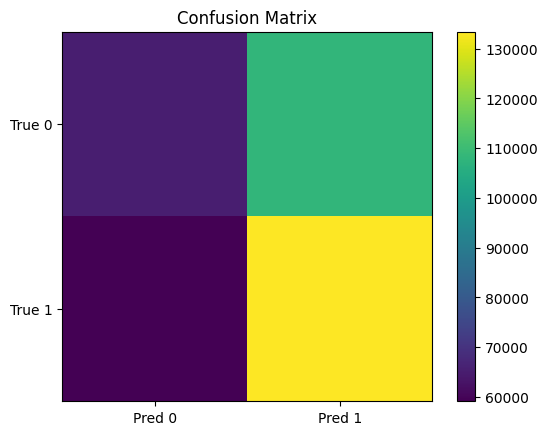

In [42]:
cm = confusion_matrix(y_test, pred)
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks([0,1],["Pred 0","Pred 1"])
plt.yticks([0,1],["True 0","True 1"])
plt.show()

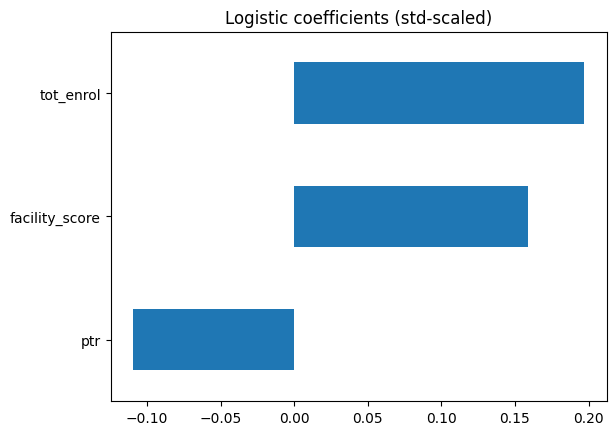

In [43]:
coef = pd.Series(clf.coef_[0], index=features)
coef.sort_values().plot(kind="barh")
plt.title("Logistic coefficients (std-scaled)")
plt.show()

In [44]:
enrol.head(), d4.head(), d5.head(), d6.head()

(   school_id  tot_b  tot_g       gpi  rep_b  rep_g  repeaters_share  cwsn_b  \
 0    1000002    118    109  0.923729      0      0              0.0       1   
 1    1000019     41     25  0.609756      0      0              0.0       1   
 2    1000021     95     97  1.021053      1      0         0.005208       1   
 3    1000028     71     41  0.577465      0      0              0.0       0   
 4    1000029    589    463  0.786078      0      0              0.0       4   
 
    cwsn_g  cwsn_share  
 0       0    0.004405  
 1       0    0.015152  
 2       4    0.026042  
 3       0         0.0  
 4       2    0.005703  ,
    school_id           state       district           block  rural_urban  \
 0    2568161         GUJARAT  SURENDRANAGAR         CHOTILA            1   
 1    3671416  MADHYA PRADESH       JABALPUR          SIHORA            1   
 2    6506534           BIHAR         SUPAUL      PRATAPGANJ            1   
 3    7566878           BIHAR          PATNA  PHULWARISHARI

In [45]:
school_master = (
    enrol
    .merge(d4, on="school_id", how="left")
    .merge(d5, on="school_id", how="left")
    .merge(d6, on="school_id", how="left")
)

In [46]:
school_master["gender_gap_flag"] = (school_master["gpi"] < 1).astype(int)

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report

feature_cols = [
    "tot_b","tot_g","repeaters_share","cwsn_share",
    "school_category","school_type","managment","rural_urban",
    "total_tch","male","female",
    "grants_receipt","grants_expenditure"
]

X = school_master[feature_cols]
y = school_master["gender_gap_flag"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=200, max_depth=12, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

pred = model.predict(X_test)
prob = model.predict_proba(X_test)[:,1]

print("ROC AUC:", roc_auc_score(y_test, prob))
print(classification_report(y_test, pred))


ROC AUC: 0.9636944518569155
              precision    recall  f1-score   support

           0       0.93      0.88      0.90    122769
           1       0.91      0.95      0.93    169927

    accuracy                           0.92    292696
   macro avg       0.92      0.91      0.92    292696
weighted avg       0.92      0.92      0.92    292696



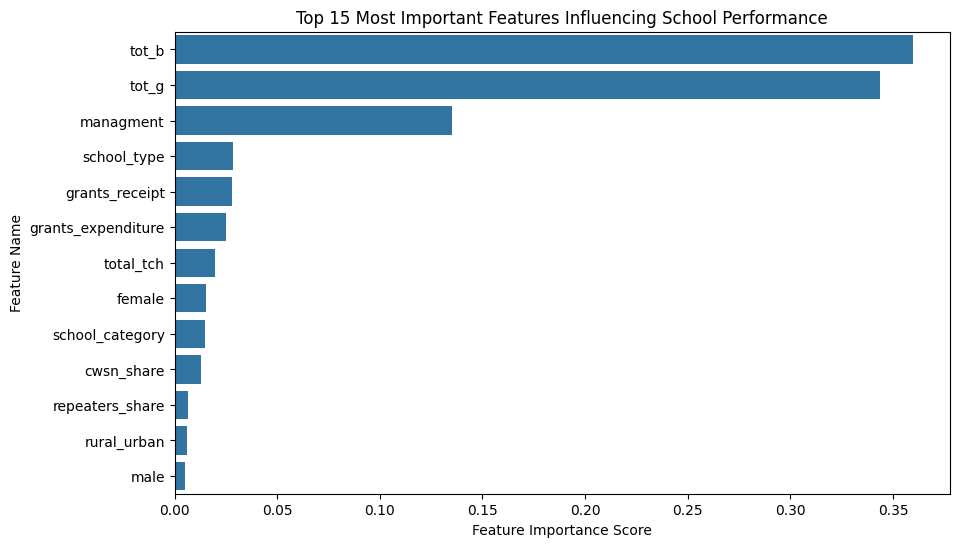

In [48]:
import seaborn as sns

feature_importance = pd.Series(model.feature_importances_, index=X_train.columns)
feature_importance = feature_importance.sort_values(ascending=False).head(15)

plt.figure(figsize=(10,6))
sns.barplot(x=feature_importance.values, y=feature_importance.index)
plt.title("Top 15 Most Important Features Influencing School Performance")
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature Name")
plt.show()

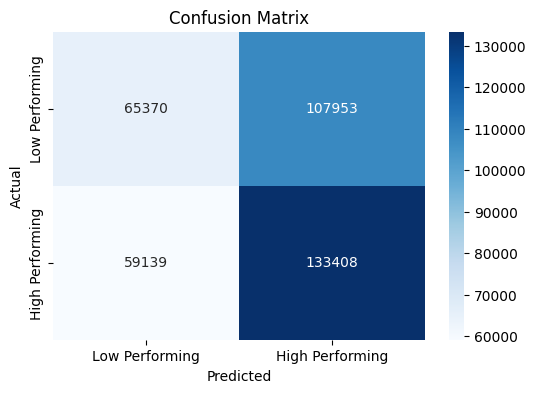

In [49]:
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=["Low Performing","High Performing"],
            yticklabels=["Low Performing","High Performing"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [50]:
y_prob = model.predict_proba(X_test)[:, 1]

In [51]:
y_prob = model.predict_proba(X_test)[:, 1]

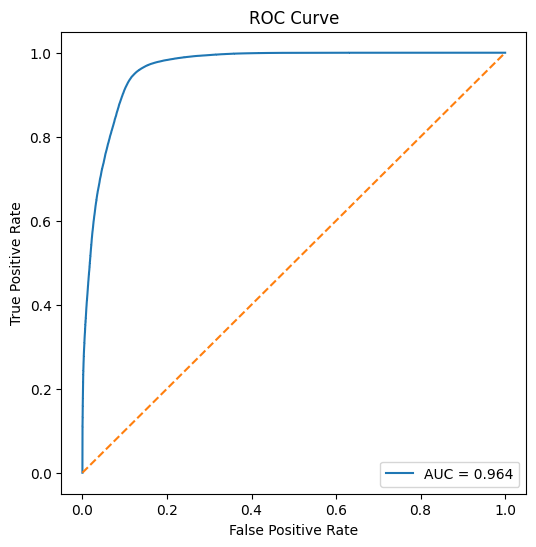

In [52]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()


In [53]:
print("Train Accuracy:", model.score(X_train, y_train))
print("Test Accuracy:", model.score(X_test, y_test))

Train Accuracy: 0.9236075996938803
Test Accuracy: 0.9191003635170962


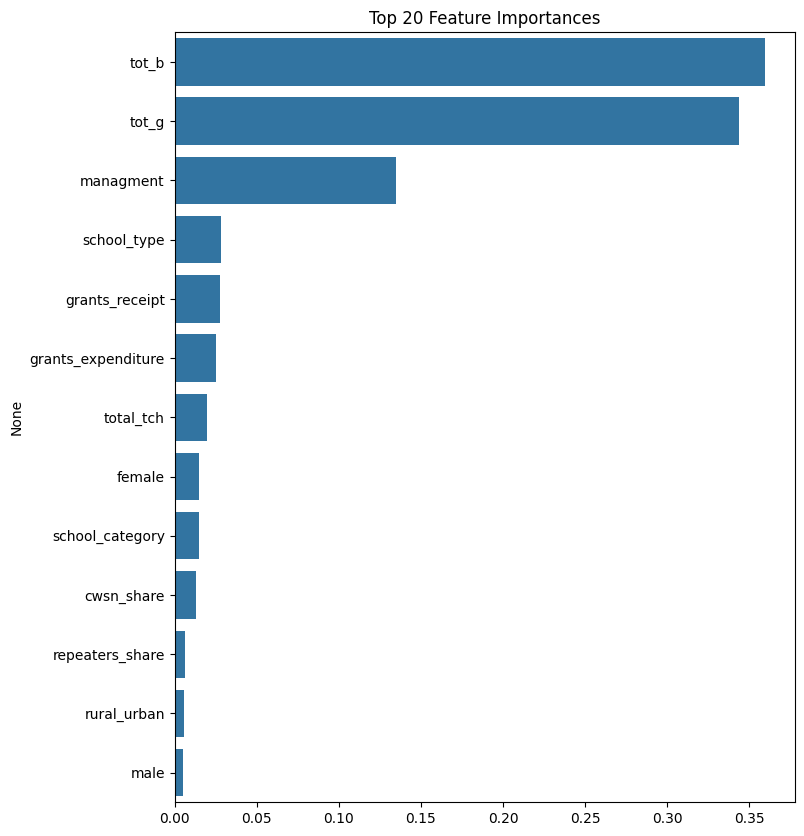

In [54]:
feat_imp = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(8,10))
sns.barplot(x=feat_imp.values[:20], y=feat_imp.index[:20])
plt.title("Top 20 Feature Importances")
plt.show()

In [55]:
feat_imp.head(20)

tot_b                 0.359579
tot_g                 0.343537
managment             0.135016
school_type           0.028566
grants_receipt        0.027853
grants_expenditure    0.025279
total_tch             0.019575
female                0.015116
school_category       0.015049
cwsn_share            0.013120
repeaters_share       0.006414
rural_urban           0.005963
male                  0.004933
dtype: float64

In [57]:
import joblib

In [59]:
joblib.dump(model, "final_model.pkl")

['final_model.pkl']

In [62]:
model = joblib.load("final_model.pkl")
y_pred = model.predict(X_test)
print("Model loaded and ready to use!")

Model loaded and ready to use!
